# About this notebook 
This notebook is a step-by-step demonstration of ``emlens`` package. As an example, we will analyze an embedding of a worldwide airport network generated by DeepWalk. See generte-embedding.py for how to generate the emebdding. 

Note that this demonstration is not comprehensive. Please see the docstring for full the desriptions of the api.

In [1]:
%load_ext autoreload
%autoreload 2
import emlens
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import sparse

# Data

In [2]:
edge_table = pd.read_csv("../data/airportnet/edges.csv")
node_table = pd.read_csv("../data/airportnet/nodes.csv")
emb = np.loadtxt("../data/airportnet/emb.txt")

### Construct the network used for generating this embedding

In [3]:
N = node_table.shape[0]
net = sparse.csr_matrix(
    (edge_table.weight, (edge_table.source, edge_table.target)), shape=(N, N)
)
deg = np.array(net.sum(axis=0)).reshape(-1)  # calculate the degree

# Step 1: Visualizing embedding space

In [4]:
# Project the emebdding space to 2d for visualization using the LDA
sx = emlens.LDASemAxis()
sx.fit(emb, node_table["region"].values)
xy = sx.transform(emb, dim = 2) # set dim =1 to get an axis

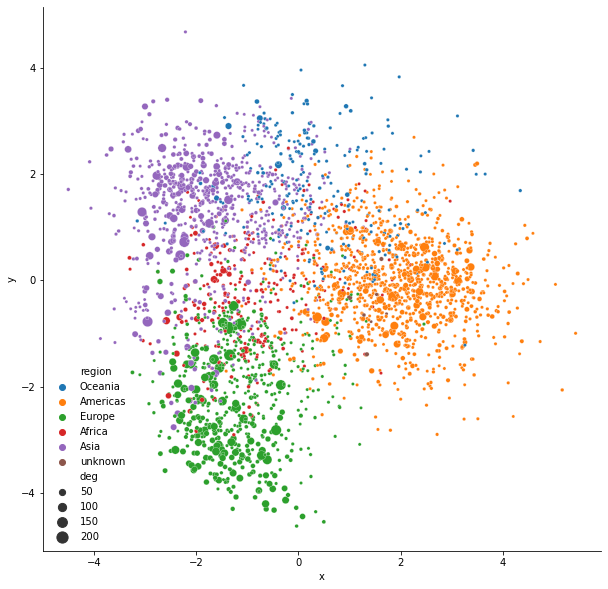

In [5]:
# Visualization
fig, ax = plt.subplots(figsize=(10, 10))
df = node_table.copy()
df["x"] = xy[:, 0]
df["y"] = xy[:, 1]
df["deg"] = deg
ax = sns.scatterplot(
    data=df, x="x", y="y", hue="region", size="deg", sizes=(10, 150), ax=ax
)
ax.legend(frameon=False)
sns.despine()

# Step 2: Calculate the correlation to node degree

In [6]:
rho = emlens.assortativity(emb, deg)

In [7]:
print("correlation to degree: %.3f" % rho)

correlation to degree: 0.674


# Step 3: Calculate the modularity

In [8]:
Qr = emlens.modularity(emb, node_table["region"].values)
Qc = emlens.modularity(emb, node_table["Country"].values)
Qrnd = emlens.modularity(emb, node_table["Country"].sample(frac=1).values)

In [9]:
print("Modularity (region): %.2f" % Qr)
print("Modularity (country): %.2f" % Qc)
print("Modularity (random): %.2f" % Qrnd)

Modularity (region): 0.60
Modularity (country): 0.64
Modularity (random): 0.13


# Step 4: Visualize group-wise similarity and distance

### dot similarity

In [10]:
S, labels = emlens.pairwise_dot_sim(emb, node_table["region"])

<AxesSubplot:>

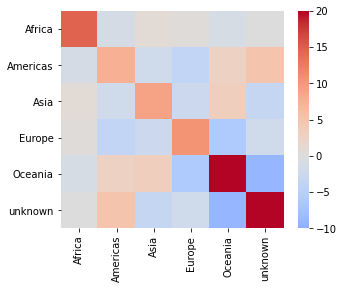

In [11]:
S = pd.DataFrame(S, index = labels, columns = labels)
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(S, cmap="coolwarm", center = 0, vmax = 20, vmin = -10, ax = ax)

### distance

In [12]:
S, labels = emlens.pairwise_distance(emb, node_table["region"])

<AxesSubplot:>

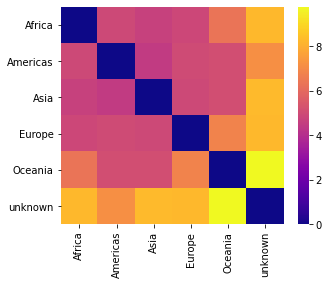

In [13]:
S = pd.DataFrame(S, index = labels, columns = labels)
fig, ax = plt.subplots(figsize=(5, 4))
sns.heatmap(S, cmap="plasma", ax = ax)

# Step 5: Find the most dense subspace 

In [14]:
density = emlens.estimate_pdf(target = emb, emb = emb)

In [15]:
df = node_table.copy()
df["density"] = density
df.sort_values(by = "density", ascending = False).head(10)

,id,Airport ID,Name,City,Country,IATA/FAA,ICAO,Latitude,Longitude,Altitude,...,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code,deg,density
255,256,580,Schiphol,Amsterdam,Netherlands,AMS,EHAM,52.308613,4.763889,-11,...,528.0,ISO 3166-2:NL,Europe,Western Europe,unknown,150.0,155.0,unknown,211,-110.868713
649,650,1524,Malpensa,Milano,Italy,MXP,LIMC,45.630606,8.728111,767,...,380.0,ISO 3166-2:IT,Europe,Southern Europe,unknown,150.0,39.0,unknown,118,-112.210159
665,666,1555,Fiumicino,Rome,Italy,FCO,LIRF,41.804475,12.250797,15,...,380.0,ISO 3166-2:IT,Europe,Southern Europe,unknown,150.0,39.0,unknown,159,-112.853577
168,168,337,Schonefeld,Berlin,Germany,SXF,EDDB,52.380001,13.522500,157,...,276.0,ISO 3166-2:DE,Europe,Western Europe,unknown,150.0,155.0,unknown,70,-112.962662
591,592,1382,Charles De Gaulle,Paris,France,CDG,LFPG,49.012779,2.550000,392,...,250.0,ISO 3166-2:FR,Europe,Western Europe,unknown,150.0,155.0,unknown,218,-113.085297
233,233,507,Heathrow,London,United Kingdom,LHR,EGLL,51.477500,-0.461389,83,...,826.0,ISO 3166-2:GB,Europe,Northern Europe,unknown,150.0,154.0,unknown,159,-113.171036
544,545,1229,Barajas,Madrid,Spain,MAD,LEMD,40.493556,-3.566764,2000,...,724.0,ISO 3166-2:ES,Europe,Southern Europe,unknown,150.0,39.0,unknown,160,-113.821625
537,538,1218,Barcelona,Barcelona,Spain,BCN,LEBL,41.297078,2.078464,12,...,724.0,ISO 3166-2:ES,Europe,Southern Europe,unknown,150.0,39.0,unknown,143,-113.841782
171,171,340,Frankfurt Main,Frankfurt,Germany,FRA,EDDF,50.026421,8.543125,364,...,276.0,ISO 3166-2:DE,Europe,Western Europe,unknown,150.0,155.0,unknown,242,-113.967041
681,682,1606,Luqa,Malta,Malta,MLA,LMML,35.857497,14.477500,300,...,470.0,ISO 3166-2:MT,Europe,Southern Europe,unknown,150.0,39.0,unknown,60,-114.119095


# Step 6: Calculate radius of gyration (ROG) for each country
ROG is the standard deviation of distance of embedding vectors from their center, capturing a spread of embedding vectors around the center. 

In [16]:
rogs = []
node_table["id"] = np.arange(node_table.shape[0])
for label, df in node_table.groupby("Country"):
    if df.shape[0] <=1 :continue
    emb_by_region = emb[df.id, :]
    rog = emlens.rog(emb_by_region, metric='cos')
    rogs+=[{"ROG":rog, "Country":label}]
rog_table = pd.DataFrame(rogs)

In [17]:
print("**** Countries with the highest ROG ****")
display(rog_table.sort_values(by = "ROG", ascending = False).head(10))

print("**** Countries with the smallest ROG ****")
display(rog_table.sort_values(by = "ROG", ascending = False).tail(10))

**** Countries with the highest ROG ****


,ROG,Country
140,0.647899,United States
22,0.643297,Canada
15,0.494780,Brazil
5,0.477795,Australia
125,0.470451,Sweden
46,0.460796,France
70,0.453504,Kenya
109,0.442694,Russia
137,0.441573,Ukraine
96,0.436317,Norway


**** Countries with the smallest ROG ****


,ROG,Country
71,0.102013,Kiribati
111,0.100659,Saint Kitts and Nevis
72,0.096870,Kyrgyzstan
28,0.089438,Comoros
146,0.086269,Virgin Islands
13,0.084124,Bosnia and Herzegovina
86,0.080884,Montenegro
113,0.076353,Saint Vincent and the Grenadines
20,0.055137,Cambodia
16,0.051381,British Virgin Islands
